#### This notebooks works with the code from the edm paper: https://github.com/NVlabs/edm


In [1]:
import tqdm
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
import matplotlib.pyplot as plt

from torch_utils import distributed as dist
from torch_utils import misc

/home/sbordt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_root = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained'
network_pkl= f'{model_root}/edm-cifar10-32x32-cond-vp.pkl'
device=torch.device('cuda')

c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path='datasets/cifar10-32x32.zip', use_labels=False, xflip=False, cache=True)
c.data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=2, prefetch_factor=2)
seed = 0
batch_size           = 64,     # Limit batch size per GPU, None = no limit.

## Load the diffusion model and CIFAR10 dataset

In [3]:
# Load CIAR10 dataset.
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seed)
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=64, **c.data_loader_kwargs))

Loading dataset...


In [4]:
# Load network.
# it is of type EDMPrecond so the pre-conditioning discussed in the paper is performed by net automaticall. that is net computes effectivly D_\theta(x,sigma,class-conditioning)
print(f'Loading network from "{network_pkl}"...')
with dnnlib.util.open_url(network_pkl) as f:
    net = pickle.load(f)['ema'].to(device)

Loading network from "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl"...


In [5]:
print("Network Supports Noise Level (Min/Max):", net.sigma_min, net.sigma_max)

Network Supports Noise Level (Min/Max): 0 inf


In [6]:
def save_image_grid(dest_path, x, gridh=8, gridw=8):
    # Save image grid.
    print(f'Saving image grid to "{dest_path}"...')
    image = (x * 127.5 + 128).clip(0, 255).to(torch.uint8)
    image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
    image = image.cpu().numpy()
    pil_img = PIL.Image.fromarray(image, 'RGB')
    pil_img.save(dest_path)
    plt.imshow(pil_img)
    plt.show()
    print('Done.')

In [7]:
x = torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)

Saving image grid to "random.png"...


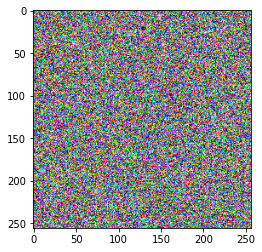

Done.


In [8]:
save_image_grid('random.png', x)

## Generate Images with the diffusion model

Generating 64 images...


  0%|          | 0/18 [00:00<?, ?step/s]

Saving image grid to "update0.png"...


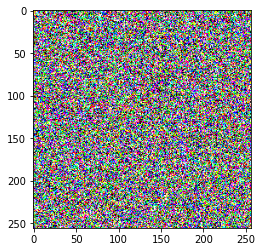

  6%|▌         | 1/18 [00:00<00:12,  1.40step/s]

Done.
Saving image grid to "update1.png"...


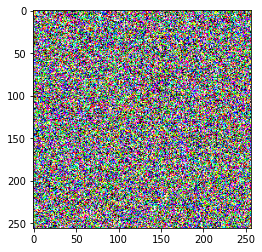

 11%|█         | 2/18 [00:01<00:11,  1.43step/s]

Done.
Saving image grid to "update2.png"...


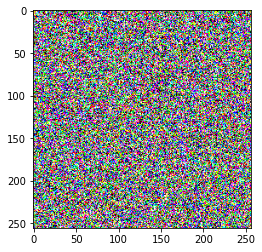

 17%|█▋        | 3/18 [00:02<00:10,  1.43step/s]

Done.
Saving image grid to "update3.png"...


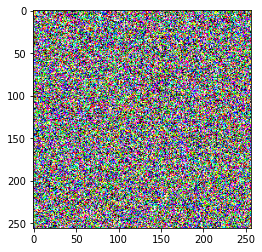

 22%|██▏       | 4/18 [00:02<00:09,  1.44step/s]

Done.
Saving image grid to "update4.png"...


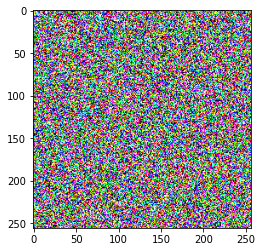

 28%|██▊       | 5/18 [00:03<00:09,  1.43step/s]

Done.
Saving image grid to "update5.png"...


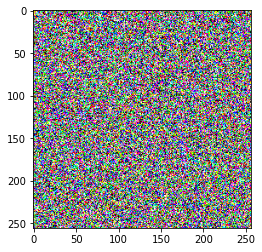

 33%|███▎      | 6/18 [00:04<00:08,  1.43step/s]

Done.
Saving image grid to "update6.png"...


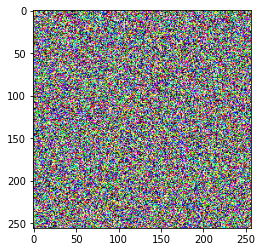

 39%|███▉      | 7/18 [00:04<00:07,  1.43step/s]

Done.
Saving image grid to "update7.png"...


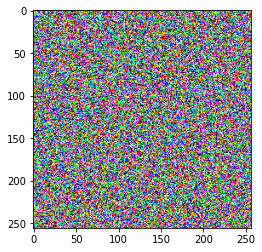

 44%|████▍     | 8/18 [00:05<00:06,  1.43step/s]

Done.
Saving image grid to "update8.png"...


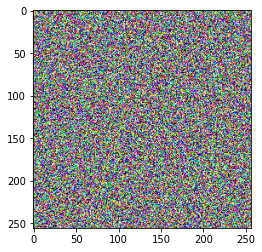

 50%|█████     | 9/18 [00:06<00:06,  1.43step/s]

Done.
Saving image grid to "update9.png"...


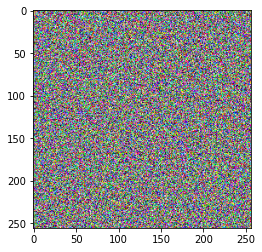

 56%|█████▌    | 10/18 [00:06<00:05,  1.44step/s]

Done.
Saving image grid to "update10.png"...


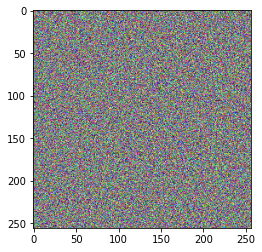

 61%|██████    | 11/18 [00:07<00:04,  1.44step/s]

Done.
Saving image grid to "update11.png"...


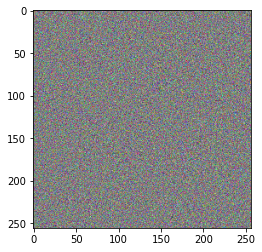

 67%|██████▋   | 12/18 [00:08<00:04,  1.44step/s]

Done.
Saving image grid to "update12.png"...


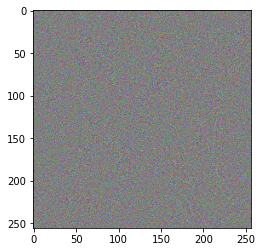

 72%|███████▏  | 13/18 [00:09<00:03,  1.45step/s]

Done.
Saving image grid to "update13.png"...


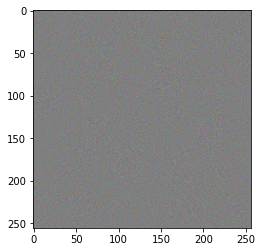

 78%|███████▊  | 14/18 [00:09<00:02,  1.44step/s]

Done.
Saving image grid to "update14.png"...


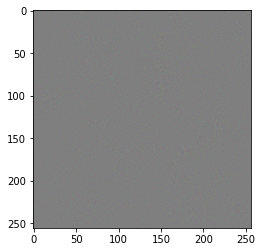

 83%|████████▎ | 15/18 [00:10<00:02,  1.44step/s]

Done.
Saving image grid to "update15.png"...


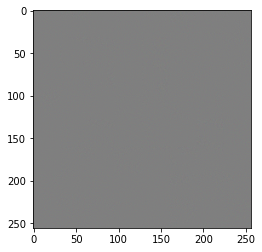

 89%|████████▉ | 16/18 [00:11<00:01,  1.42step/s]

Done.
Saving image grid to "update16.png"...


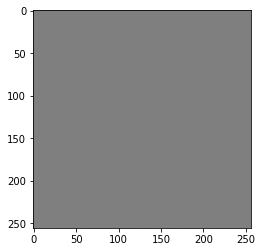

 94%|█████████▍| 17/18 [00:11<00:00,  1.43step/s]

Done.
Saving image grid to "update17.png"...


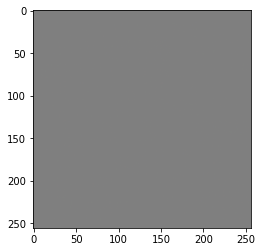

100%|██████████| 18/18 [00:12<00:00,  1.47step/s]

Done.
Saving image grid to "cifar-10-generated.png"...


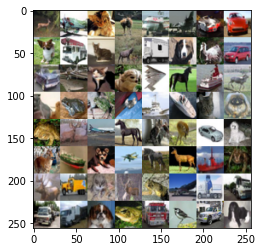

Done.


In [20]:
seed=0
gridw=8
gridh=8
num_steps=18
sigma_min=0.002
sigma_max=80
rho=7
S_churn=0
S_min=0
S_max=float('inf')
S_noise=1

batch_size = gridw * gridh
torch.manual_seed(seed)

# Pick latents and labels.
print(f'Generating {batch_size} images...')
latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
class_labels = None
if net.label_dim:
    class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)

# Time step discretization.
step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

# Main sampling loop.
x_next = latents.to(torch.float64) * t_steps[0]
for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1
    x_cur = x_next

    # Increase noise temporarily.
    gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
    t_hat = net.round_sigma(t_cur + gamma * t_cur) # 5:
    x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)  # 6:

    # Euler step.
    denoised = net(x_hat, t_hat, class_labels).to(torch.float64) # 7:
    d_cur = (x_hat - denoised) / t_hat # 7:
    x_next = x_hat + (t_next - t_hat) * d_cur # 8:

    # Apply 2nd order correction.
    if i < num_steps - 1:
        denoised = net(x_next, t_next, class_labels).to(torch.float64)
        d_prime = (x_next - denoised) / t_next
        x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    save_image_grid(f'update{i}.png', x_next-x_cur)

save_image_grid('cifar-10-generated.png', x_next)

In [17]:
t_steps, sigma_min, sigma_max

(tensor([8.0000e+01, 5.7586e+01, 4.0786e+01, 2.8375e+01, 1.9352e+01, 1.2910e+01,
         8.4009e+00, 5.3152e+00, 3.2568e+00, 1.9233e+00, 1.0882e+00, 5.8535e-01,
         2.9644e-01, 1.3952e-01, 5.9947e-02, 2.2935e-02, 7.5280e-03, 2.0000e-03,
         0.0000e+00], device='cuda:0', dtype=torch.float64),
 0.002,
 80)

Saving image grid to "out.png"...


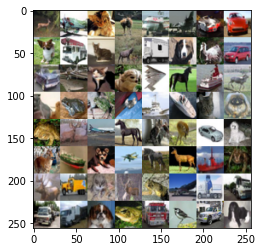

Done.


In [22]:
save_image_grid(f'out.png', x_next)

## Inspect the data + various levels of noise

In [12]:
images = dataset_iterator.__next__()
images = images[0].to(device).to(torch.float32) / 127.5 - 1

Saving image grid to "images_0.002.png"...


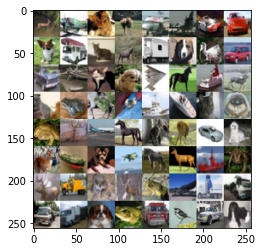

Done.
Saving image grid to "images_0.1.png"...


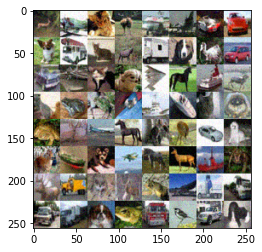

Done.
Saving image grid to "images_0.2.png"...


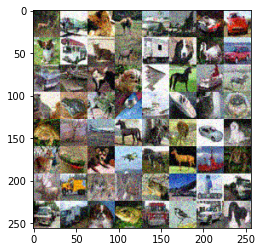

Done.
Saving image grid to "images_0.5.png"...


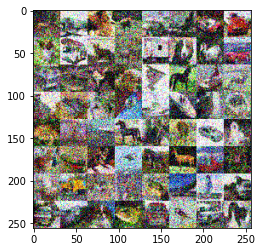

Done.
Saving image grid to "images_1.png"...


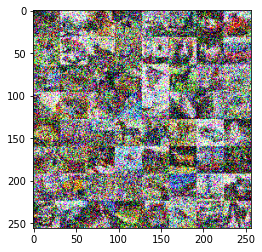

Done.
Saving image grid to "images_2.png"...


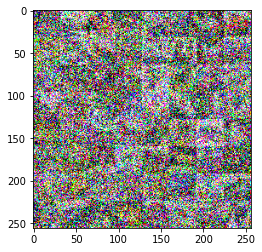

Done.
Saving image grid to "images_4.png"...


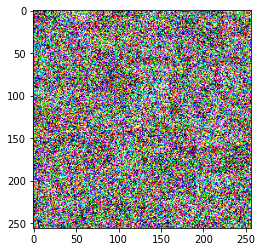

Done.
Saving image grid to "images_8.png"...


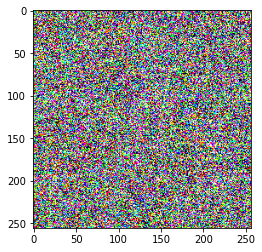

Done.


In [28]:
for i in [0.002, 0.1, 0.2, 0.5, 1, 2, 4, 8]:
    sigma = torch.Tensor([i]).to(device)
    noisy_images = images + sigma * torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    save_image_grid(f'images_{i}.png', noisy_images)

## Inspect the scaling of the network output, score etc. wrt. sigma

In [7]:
images = dataset_iterator.__next__()
images = images[0].to(device).to(torch.float32) / 127.5 - 1

In [43]:
noise_level = np.logspace(-3, 1, num=25)
noisy_images = {}
denoiser_noisy = {}   
denoiser_original = {} 
for t in tqdm.tqdm(noise_level):
    sigma = net.round_sigma(torch.Tensor([t]).to(device))
    nimg = images + sigma * torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    D = net(nimg, sigma).to(torch.float64) # , class_labels
    noisy_images[t] = nimg.detach().cpu()
    denoiser_noisy[t] = D.detach().cpu()
    D = net(images, sigma).to(torch.float64) # , class_labels
    denoiser_original[t] = D.detach().cpu()

100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


In [48]:
noise_norm = []
denoised_norm = []
orignal_norm = []
score_norm = []

for t in noise_level:
    noise = t * torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    noise_norm.append( torch.linalg.vector_norm(noise, dim=(1,2,3)).mean().item() )

    nimg = noisy_images[t]
    D = denoiser_noisy[t]
    denoised_norm.append( torch.linalg.vector_norm(D-nimg, dim=(1,2,3)).mean().item() )

    D = denoiser_original[t]
    orignal_norm.append( torch.linalg.vector_norm(D-images.detach().cpu(), dim=(1,2,3)).mean().item() )

    D = denoiser_noisy[t]
    score = (D - nimg.detach().cpu()) / t.item() ** 2
    score_norm.append( torch.linalg.vector_norm(score, dim=(1,2,3)).mean().item() )

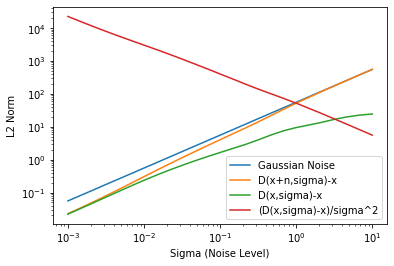

In [49]:
#plt.plot(noise_level, score_norm, label='Score Norm (L2)')
#plt.plot(noise_level, score_norm * noise_level ** 2, label='Network Output - Image (L2)')
#plt.plot(noise_level, 1 / noise_level ** 2, label='1/Noise Level^2')
#plt.plot(noise_level, noise_norm, label='L2 Norm auf Gaussian Noise')

plt.plot(noise_level, noise_norm, label='Gaussian Noise')
plt.plot(noise_level, denoised_norm, label='D(x+n,sigma)-x')
plt.plot(noise_level, orignal_norm, label='D(x,sigma)-x')
plt.plot(noise_level, score_norm, label='(D(x,sigma)-x)/sigma^2')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('L2 Norm')
plt.xlabel('Sigma (Noise Level)')
plt.legend()
plt.show()

## Inspect the score function as by the diffusion model on the data + various levels of noise

In [13]:
from captum.attr import visualization as viz

In [11]:
images = dataset_iterator.__next__()
images = images[0].to(device).to(torch.float32) / 127.5 - 1

In [12]:
#images = x_next

NameError: name 'x_next' is not defined

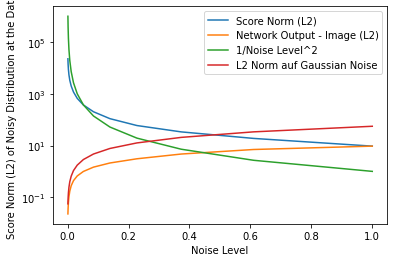

In [36]:
noise_norm = []
for t in tqdm.tqdm(noise_level):
    sigma = net.round_sigma(torch.Tensor([t]).to(device))


100%|██████████| 15/15 [00:00<00:00, 1687.53it/s]


-------- tensor([0.0020], device='cuda:0') -------
tensor(11224.1621, device='cuda:0', dtype=torch.float64) tensor([0.0449], device='cuda:0')


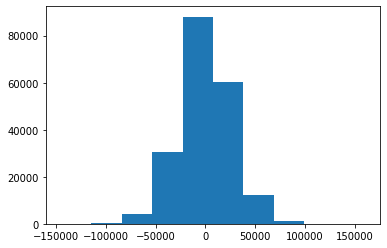

tensor(11224.1621, device='cuda:0', dtype=torch.float64) tensor([0.0449], device='cuda:0')


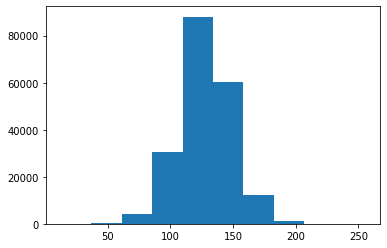

Saving image grid to "score_0.002.png"...


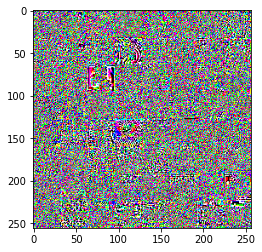

Done.
Saving image grid to "score_0.002_rescalecd.png"...


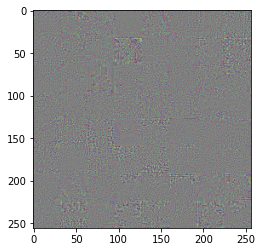

Done.
-------- tensor([0.1000], device='cuda:0') -------
tensor(164.5282, device='cuda:0', dtype=torch.float64) tensor([1.6453], device='cuda:0')


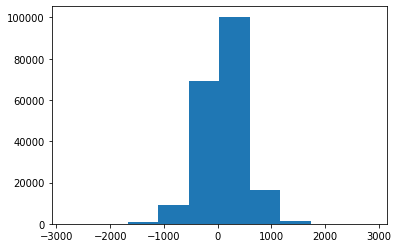

tensor(164.5282, device='cuda:0', dtype=torch.float64) tensor([1.6453], device='cuda:0')


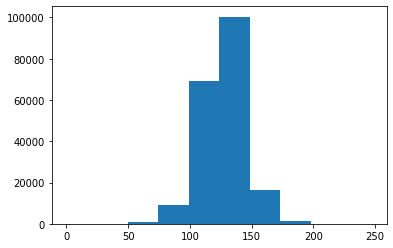

Saving image grid to "score_0.1.png"...


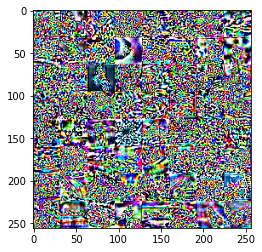

Done.
Saving image grid to "score_0.1_rescalecd.png"...


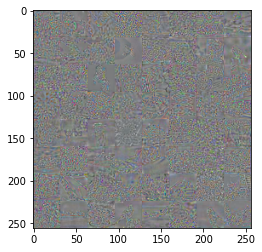

Done.
-------- tensor([0.2000], device='cuda:0') -------
tensor(68.3956, device='cuda:0', dtype=torch.float64) tensor([2.7358], device='cuda:0')


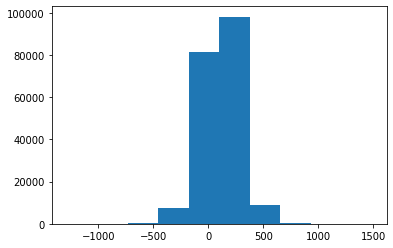

tensor(68.3956, device='cuda:0', dtype=torch.float64) tensor([2.7358], device='cuda:0')


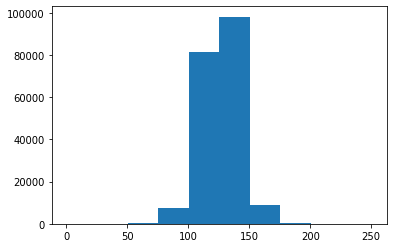

Saving image grid to "score_0.2.png"...


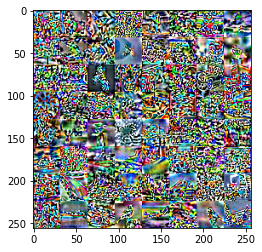

Done.
Saving image grid to "score_0.2_rescalecd.png"...


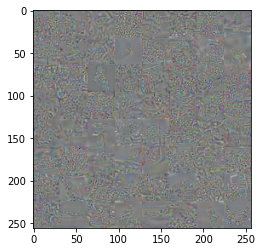

Done.
-------- tensor([0.5000], device='cuda:0') -------
tensor(23.6937, device='cuda:0', dtype=torch.float64) tensor([5.9234], device='cuda:0')


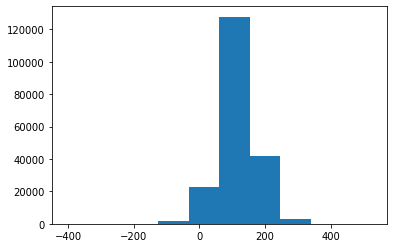

tensor(23.6937, device='cuda:0', dtype=torch.float64) tensor([5.9234], device='cuda:0')


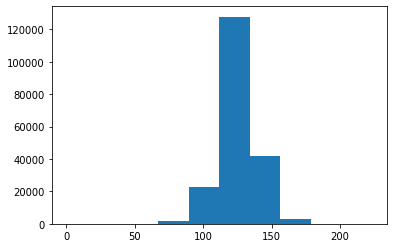

Saving image grid to "score_0.5.png"...


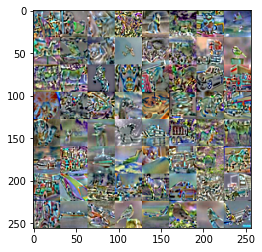

Done.
Saving image grid to "score_0.5_rescalecd.png"...


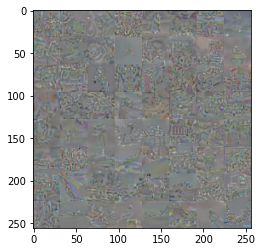

Done.
-------- tensor([0.8000], device='cuda:0') -------
tensor(13.0205, device='cuda:0', dtype=torch.float64) tensor([8.3331], device='cuda:0')


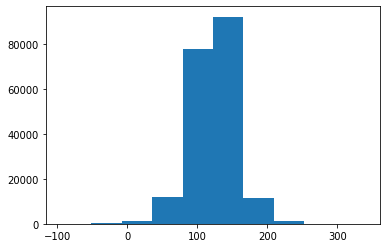

tensor(13.0205, device='cuda:0', dtype=torch.float64) tensor([8.3331], device='cuda:0')


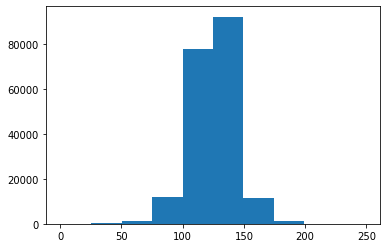

Saving image grid to "score_0.8.png"...


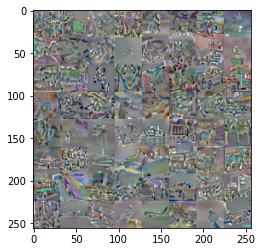

Done.
Saving image grid to "score_0.8_rescalecd.png"...


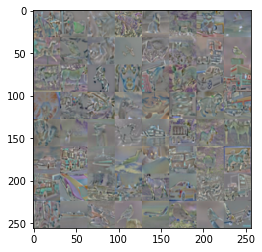

Done.
-------- tensor([1.], device='cuda:0') -------
tensor(9.4299, device='cuda:0', dtype=torch.float64) tensor([9.4299], device='cuda:0')


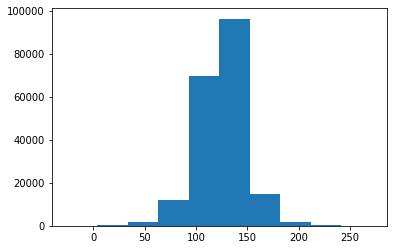

tensor(9.4299, device='cuda:0', dtype=torch.float64) tensor([9.4299], device='cuda:0')


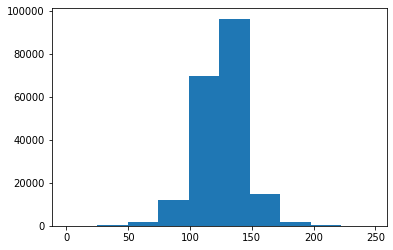

Saving image grid to "score_1.png"...


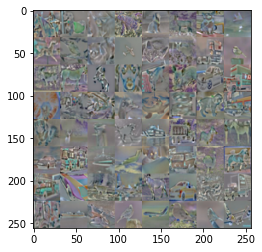

Done.
Saving image grid to "score_1_rescalecd.png"...


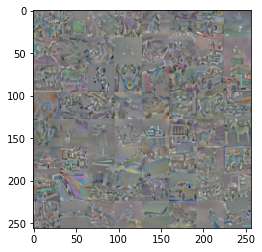

Done.
-------- tensor([2.], device='cuda:0') -------
tensor(3.2661, device='cuda:0', dtype=torch.float64) tensor([13.0644], device='cuda:0')


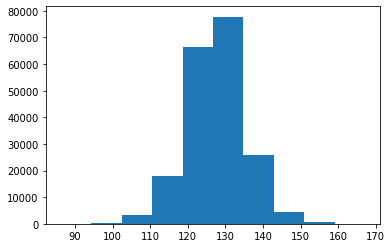

tensor(3.2661, device='cuda:0', dtype=torch.float64) tensor([13.0644], device='cuda:0')


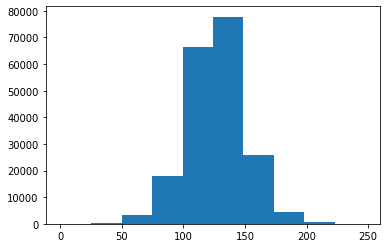

Saving image grid to "score_2.png"...


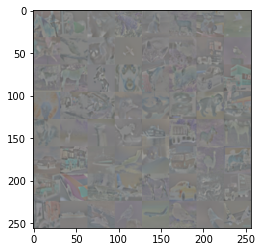

Done.
Saving image grid to "score_2_rescalecd.png"...


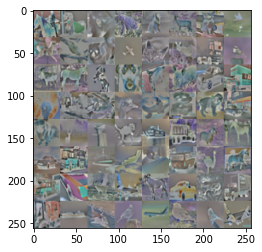

Done.
-------- tensor([4.], device='cuda:0') -------
tensor(1.1689, device='cuda:0', dtype=torch.float64) tensor([18.7018], device='cuda:0')


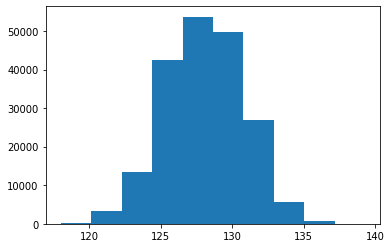

tensor(1.1689, device='cuda:0', dtype=torch.float64) tensor([18.7018], device='cuda:0')


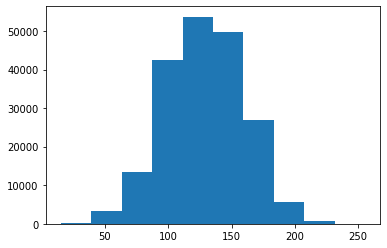

Saving image grid to "score_4.png"...


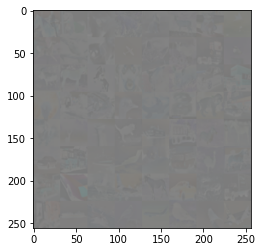

Done.
Saving image grid to "score_4_rescalecd.png"...


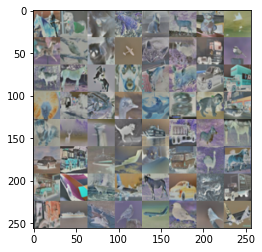

Done.
-------- tensor([8.], device='cuda:0') -------
tensor(0.3662, device='cuda:0', dtype=torch.float64) tensor([23.4381], device='cuda:0')


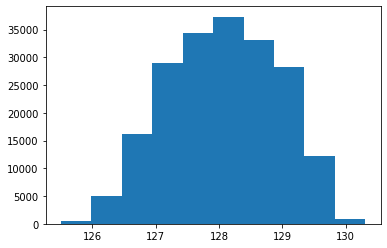

tensor(0.3662, device='cuda:0', dtype=torch.float64) tensor([23.4381], device='cuda:0')


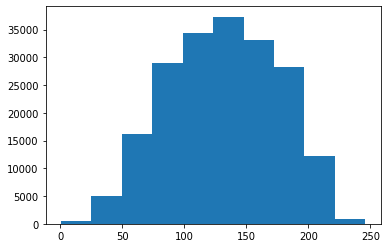

Saving image grid to "score_8.png"...


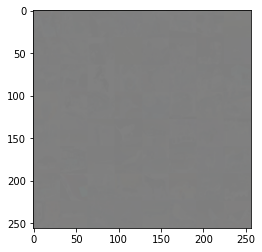

Done.
Saving image grid to "score_8_rescalecd.png"...


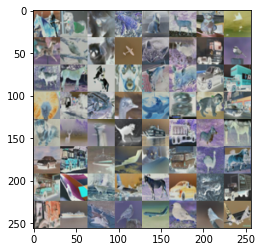

Done.


In [26]:
for i in [0.001, 0.002, 0.05, 0.2, 0.5, 0.8, 1, 2, 4, 8]:
    sigma = net.round_sigma(torch.Tensor([i]).to(device))
    noisy_images = images + sigma * torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    denoised = net(images, sigma).to(torch.float64) # , class_labels
    score = (denoised - images) / sigma ** 2
    print(f'-------- {sigma } -------')
    mean_length = torch.linalg.vector_norm(score, dim=(1,2,3)).mean()
    print(mean_length, mean_length * sigma ** 2 )
    plt.hist((score * 127.5 + 128).detach().cpu().numpy().flatten())
    plt.show()
    print(mean_length, mean_length * sigma ** 2 )
    plt.hist(((score / score.abs().max()) * 127.5 + 128).detach().cpu().numpy().flatten())
    plt.show()

    save_image_grid(f'score_{i}.png', score)
    save_image_grid(f'score_{i}_rescalecd.png', score / score.abs().max())

    #image = score.reshape(8, 8, *score.shape[1:]).permute(0, 3, 1, 4, 2)
    #image = image.reshape(8 * net.img_resolution, 8 * net.img_resolution, net.img_channels)
    #image = image.cpu().numpy()
    #viz.visualize_image_attr(image)

In [20]:
score.shape

torch.Size([64, 3, 32, 32])

In [ ]:
# magnitude of noise
#  small amount of noise does not change distribution: flat maxima, score mathcing does not work: this means score for large sigma should be the same


